# Homework 5
Biol 419/519
Winter 2018

Oliver Speltz

In [1]:
# preliminaries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## 1. Visualize the data

In [2]:
genes = np.load('CancerMicroarray.npy')
c_types = np.load('CancerTypes.npy')
c_names = {1 : 'BL', 2 : 'EWS', 3 : 'NB', 4 : 'RMS'}
print('genes',type(genes),genes.shape)
print('c_types',type(c_types),c_types.shape)

genes <class 'numpy.ndarray'> (83, 2308)
c_types <class 'numpy.ndarray'> (83,)


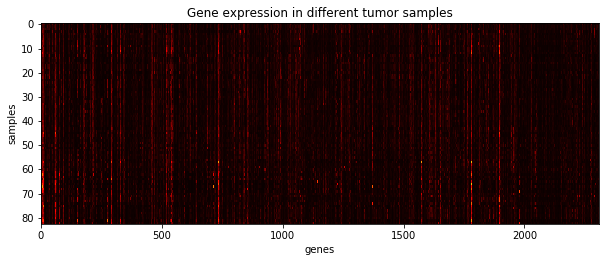

In [3]:
fig,ax = plt.subplots(figsize=(10,6))
ax.imshow(genes,cmap='hot',aspect=10)
ax.set_xlabel('genes')
ax.set_ylabel('samples')
ax.set_title('Gene expression in different tumor samples');

# 2. Principle Components

In [4]:
genes0 = genes - genes.mean(axis=0) # center data around origin
u,s,v = np.linalg.svd(genes0,full_matrices=False)
s_norm = s/s.sum()
cumu = np.zeros(len(s))
for r in range(len(s_norm)):
    cumu[r] = s_norm[:r+1].sum()
min_r = np.argmax(cumu >= 0.9)
print('u',u.shape,)
print('v',v.shape)

u (83, 83)
v (83, 2308)


62 is the minimum number of principle components needs to explain 90% of the variance


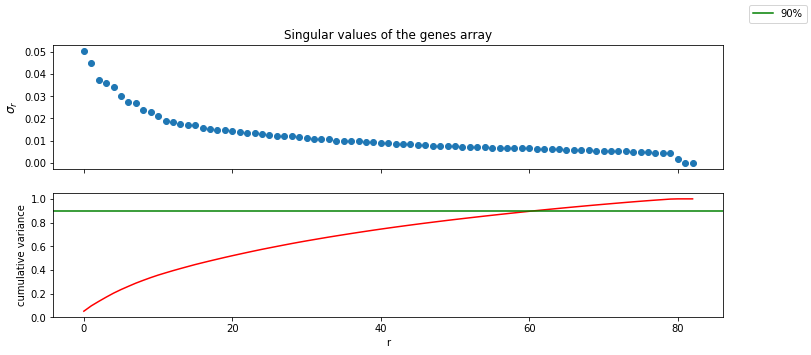

In [5]:
fig,axes = plt.subplots(nrows=2,figsize=(12,5),sharex=True)
axes[0].plot(s/s.sum(),'o')
axes[0].set_ylabel('$\sigma_r$',fontsize=12)
axes[0].set_title('Singular values of the genes array')
axes[1].plot(cumu,'r')
axes[1].axhline(0.9,color='g',label='90%')
axes[1].set_xlabel('r')
axes[1].set_ylabel('cumulative variance')
fig.legend();
print(min_r+1,'is the minimum number of principle components needs to explain 90% of the variance')

It seems that there aren't really any dominant components. 62 of them are need to explain 90% of the variance.

In [6]:
PCs = genes @ v.T @ np.diag(1/s)
print('Principle component projection',PCs.shape)

Principle component projection (83, 83)


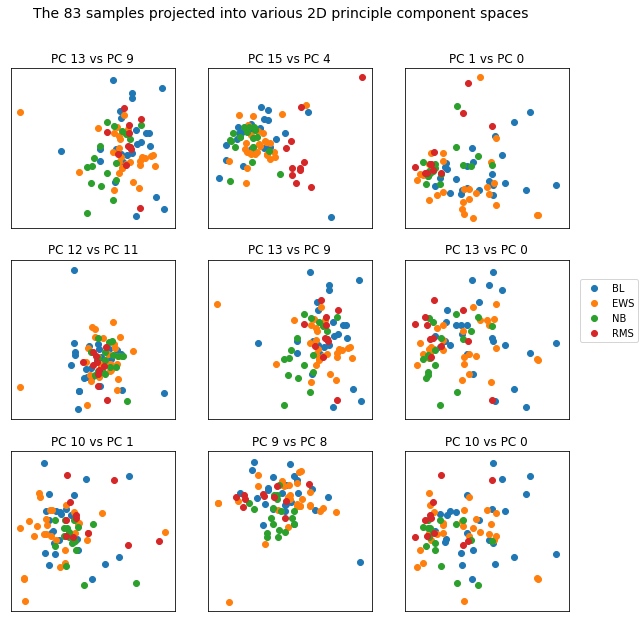

In [7]:
fig,axes = plt.subplots(3,3,figsize=(10,10))
np.random.seed(10)
for p,ax in enumerate(axes.flatten()):
    i = np.random.randint(16)
    j = np.random.randint(16)
    while i == j:
        j = np.random.randint(16)
    for x in range(1,5):
        inds = c_types == x
        lab = None
        if p+1 == axes.size:
            lab = c_names[x]
        ax.scatter(PCs[inds,i],PCs[inds,j],label=lab)
    ax.set_title('PC {} vs PC {}'.format(j,i))
    ax.set_xticks([]), ax.set_yticks([])
fig.legend(loc='center right')
fig.text(0.5,0.95,'The 83 samples projected into various 2D principle component spaces',
        ha='center',fontsize=14);

Seemingly, no 2d combination of principle components gives a clear separation of the different cancer types, here represented by different colors.

# 3. Classifiers and cross validation

In [8]:
def test_train_id(N,test_frac):
    n = int(test_frac * N)
    ids = np.arange(N)
    np.random.shuffle(ids)
    return ids[:n], ids[n:]

train, test = test_train_id(80,0.3)
print(train,len(train))
print(test,len(test))
print(all(i not in test for i in train))
print(all(i not in train for i in test))

[70 43  3 21 52 14 55 58 61 46 63 19 26  0 37 39 48  6 34 69 45  8  2 53] 24
[60 44 59 35 38  4  5 74 41 32 20 73 71 79 42 17 50 47  7 77 56 15  9 24
 10 28 76 64 23 22 66 29 18 27 78 57 31  1 12 67 65 30 68 25 13 75 51 49
 72 33 62 54 11 16 36 40] 56
True
True


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

def classifier_cross_val_acc(model,X,y,rank,test_frac,reps):
    acc = []
    for i in range(reps):
        testid,trainid = test_train_id(len(y),test_frac)
        test_data = X[testid,:]
        test_labs = y[testid]
#         test_data -= test_data.mean(axis=0)
        train_data = X[trainid,:]
        train_labs = y[trainid]
        train_mean = train_data.mean(axis=0)
        train_data -= train_mean
        u,s,v = np.linalg.svd(train_data,full_matrices=False)
        train_PCs = train_data @ v.T @ np.diag(1/s)
        model.fit(train_PCs[:,:rank],train_labs)
        test_data -= train_mean
        test_PCs = test_data @ v.T @ np.diag(1/s)
        prediction = model.predict(test_PCs[:,:rank])
        trial = sum(prediction == test_labs) / len(test_labs)
        acc.append(trial)
    return np.mean(acc)
    
    
classy = KNeighborsClassifier(n_neighbors=2)
acc = classifier_cross_val_acc(classy,genes,c_types,10,0.2,100)
print('''The mean cross validated accuracy for a 2 nearest neighbors model
considering the first 10 principle components is''',acc)

The mean cross validated accuracy for a 2 nearest neighbors model
considering the first 10 principle components is 0.885625


# 4. Comparing classifiers

In [14]:
knn_2_20 = KNeighborsClassifier(n_neighbors=2)
knn_10_20 = KNeighborsClassifier(n_neighbors=10)
lda_5 = LinearDiscriminantAnalysis()
lda_20 = LinearDiscriminantAnalysis()
svm_20 = SVC(kernel='linear')
tree_20 = DecisionTreeClassifier()

models = [knn_2_20,knn_10_20,lda_5,lda_20,svm_20,tree_20]
ranks = [20,20,5,20,20,20]
accs = []
for model,rank in zip(models,ranks):
    acc = classifier_cross_val_acc(model,genes,c_types,
                                  rank,0.2,200)
    accs.append(acc)

[0.8859375, 0.8428125, 0.7478125, 0.9978125, 0.8696875, 0.7709375]

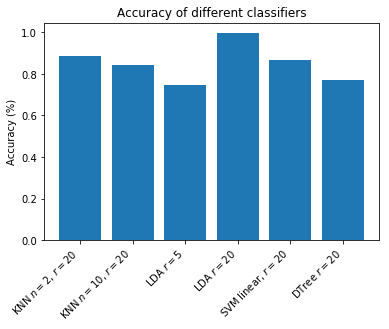

In [17]:
names = ['KNN $n=2$, $r=20$', 'KNN $n=10$, $r=20$', 'LDA $r=5$',
        'LDA $r=20$', 'SVM linear, $r=20$', 'DTree $r=20$']
plt.bar(range(6),accs)
plt.xticks(range(6),names,rotation=45,ha='right')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of different classifiers');
accs

I spent about 4.5 hours on this assignment, alone. I did cross validate my answers with Yutaro Sakairi.

Shout out Nathan Kutz